In [1]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
"""
this cell calibrates the camera and saves calibration 
values as a pickle
"""
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[:9, :6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if ret:
    p = {}
    p['cmtx'] = mtx
    p['dCoefs'] = dist
    pickle.dump(p, open('camera_cal/camera_params.p', 'wb'))
        

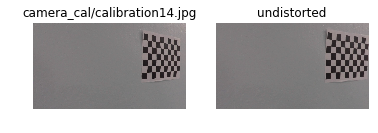

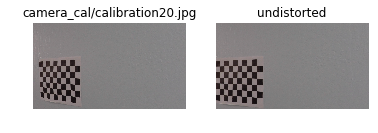

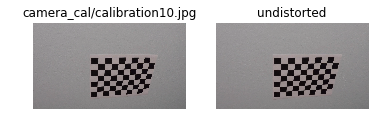

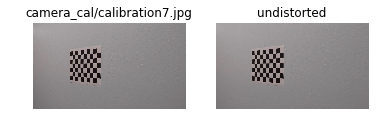

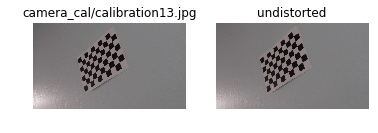

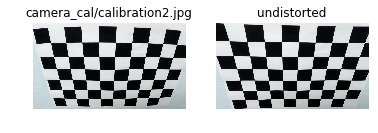

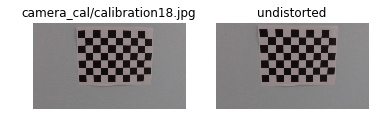

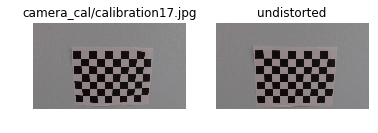

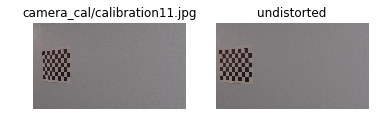

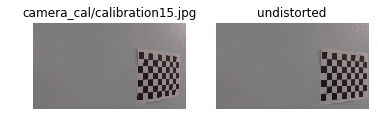

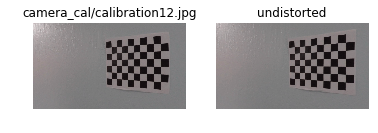

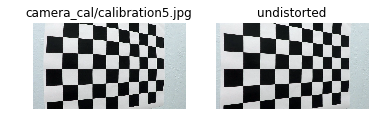

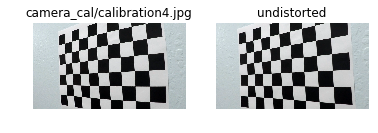

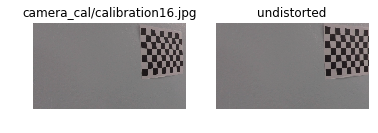

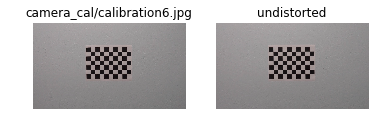

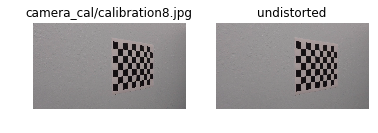

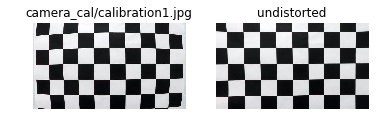

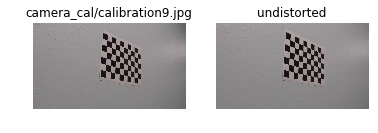

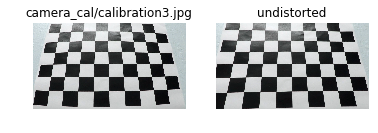

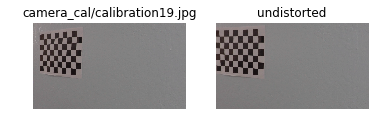

In [3]:
images = glob.glob('camera_cal/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    plt.subplot(1, 2, 1 )
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(1, 2, 2 )
    plt.imshow(undistorted)
    plt.title('undistorted')
    plt.axis('off')
    plt.show()

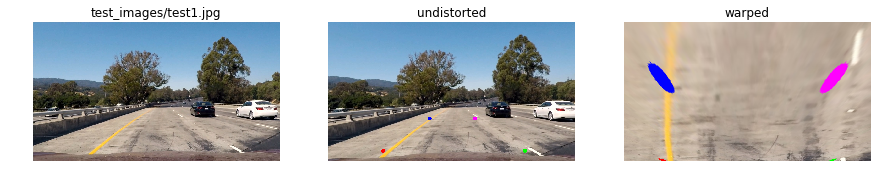

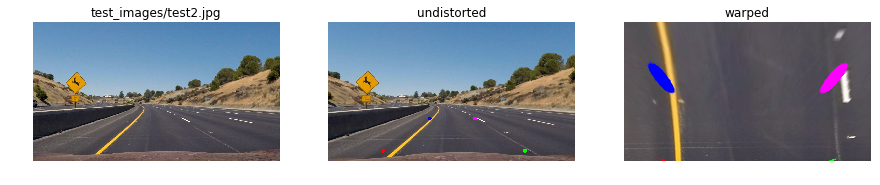

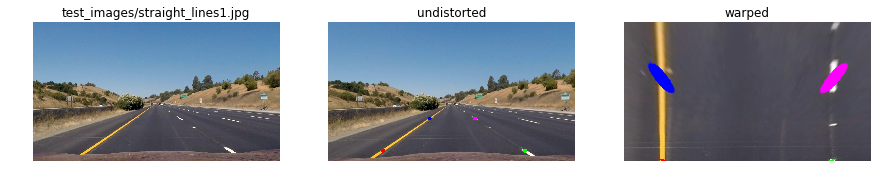

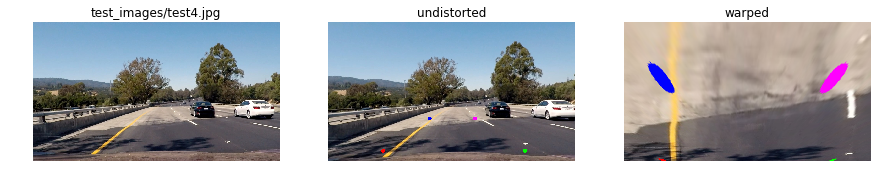

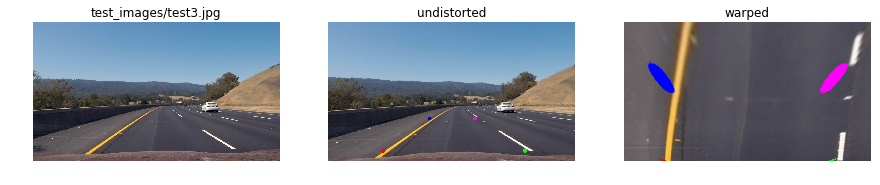

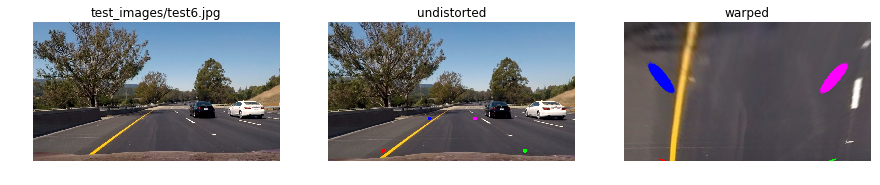

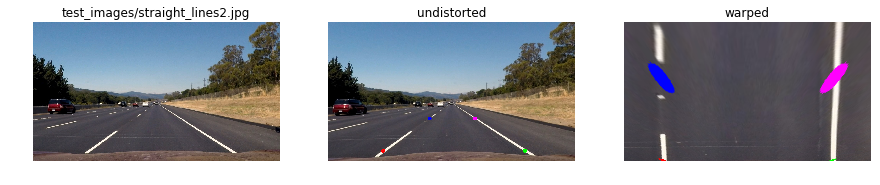

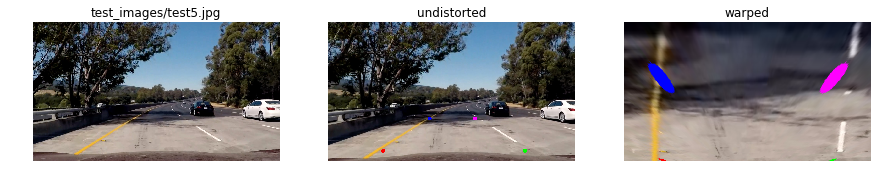

In [4]:
"""
this cell is for finding optimal src and dst points for the 
perspective transformation.

the points about which the image is warped are marked as colored dots.
"""
cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')

    undistorted = cv2.undistort(img, cmtx, dCoefs, None, cmtx)
    x,y = undistorted.shape[:2][::-1]
    src_transform_pts = np.float32([[286, 666], [1020, 666], [527, 500], [761, 500]])
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,0,255)]
    for pt, col in zip(src_transform_pts, colors):
        cv2.circle(undistorted, tuple(pt), 10, col, -1)
    dst_transform_pts = np.float32([[200, y-5], [x-200, y-5], [200, 300], [x-200, 300]])
    m = cv2.getPerspectiveTransform(src_transform_pts, dst_transform_pts)
    warped = cv2.warpPerspective(undistorted, m, (x, y))
    
    plt.subplot(1, 3, 2)
    plt.imshow(undistorted)
    plt.title('undistorted')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(warped)
    plt.title('warped')
    plt.axis('off')
    plt.show()
    
    cam_params['x'] = x
    cam_params['y'] = y
    cam_params['src_pts'] = src_transform_pts
    cam_params['dst_pts'] = dst_transform_pts
    cam_params['transform'] = m
pickle.dump(cam_params, open('camera_cal/camera_params.p', 'wb'))
    

In [5]:
""" 
this cell contains functions for adjusting color space to highlight
lane lines
"""
def s_thresh(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    
    sbinary = np.zeros_like(s_chan)
    sbinary[(s_chan >= thresh[0]) & (s_chan <= thresh[1])] = 1
    
    return sbinary

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError("orient should be x or y")
    
    sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * sobel/np.max(sobel))
    binary_out = np.zeros_like(scaled_sobel)
    binary_out[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_out

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    binary_out = np.zeros_like(mag_sobel)
    binary_out[(mag_sobel >= thresh[0]) & (mag_sobel <= thresh[1])] = 1
    return binary_out

def dir_thresh(gray, sobel_kernel=3, thresh=(0,np.pi/2)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.absolute(np.arctan2(sobel_y, sobel_x))
    binary_out = np.zeros_like(dir_sobel)
    binary_out[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])]
    return binary_out

def equalize(img):
    img = img.copy()
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

def threshold(rgb_img):
    rgb_image = equalize(rgb_img)
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    x_bin = abs_sobel_thresh(gray, thresh=(10,255))
    y_bin = abs_sobel_thresh(gray, orient='y', thresh=(60,255))
    mag_bin = mag_thresh(gray, thresh=(40,255))
    dir_bin = dir_thresh(gray, thresh=(.65,1.05))
    s_bin = s_thresh(rgb_img)
    
    combined = np.zeros_like(gray)
    combined[((x_bin == 1) & (y_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1)) | (s_bin == 1)] = 1
    return combined
    

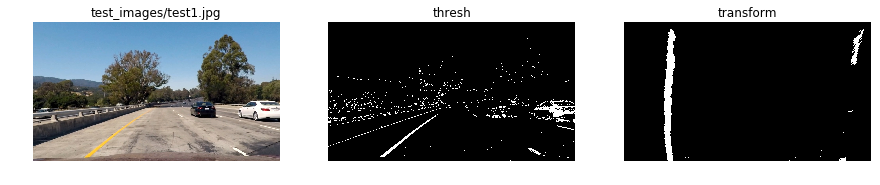

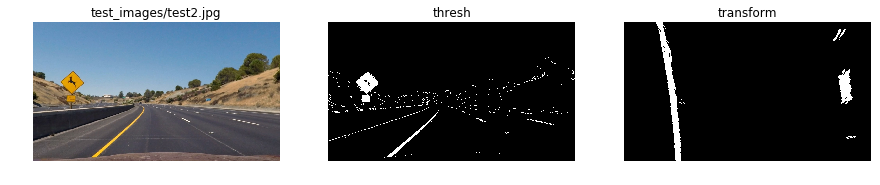

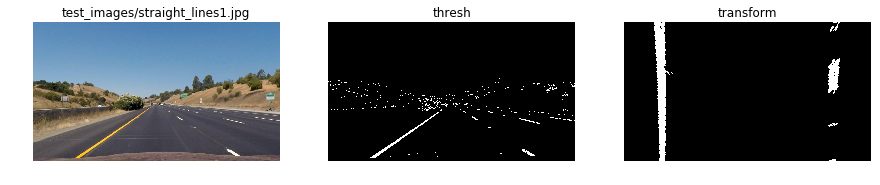

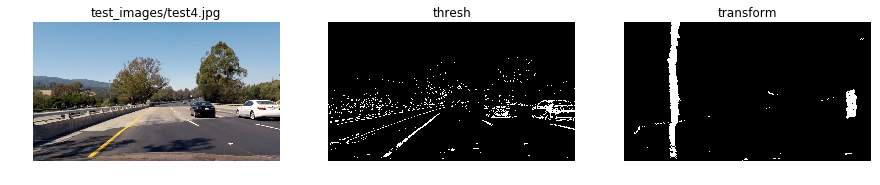

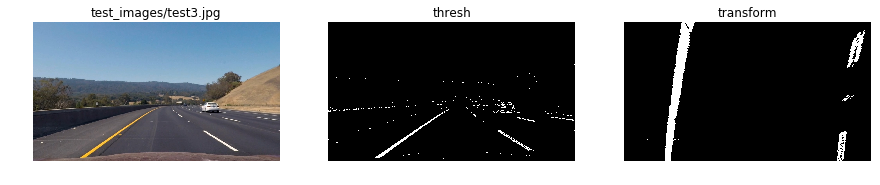

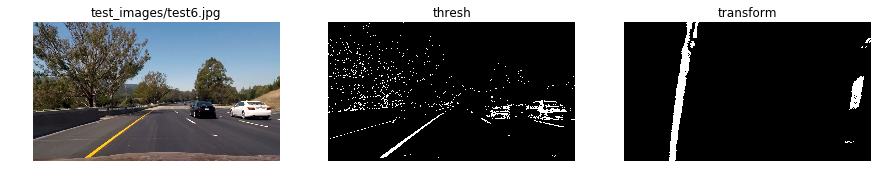

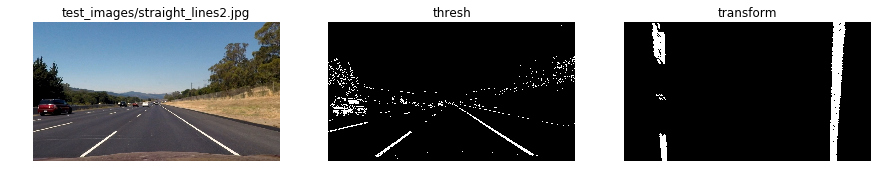

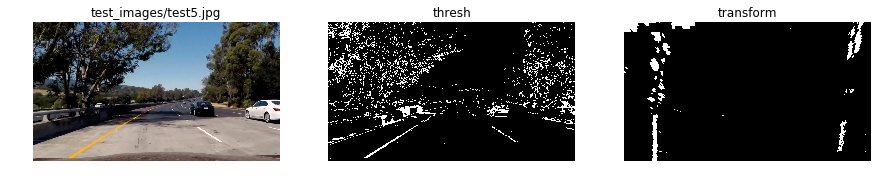

In [6]:
"""
this cell is for debugging the color thresholding functions
defined in the previous cell
"""
warped = []
origs = []
cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
m = cam_params['transform']
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
x = cam_params['x']
y = cam_params['y']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, cmtx, dCoefs, None, cmtx) 
    origs.append(img)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
    
    thresh = threshold(img)
    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("thresh")
    plt.axis('off')
    
    transform = cv2.warpPerspective(thresh, m, (x, y))
    warped.append(transform)
    plt.subplot(1, 3, 3)
    plt.imshow(transform, cmap='gray')
    plt.title("transform")
    plt.axis('off')
    plt.show
    

In [7]:
"""
performs sliding window search to get equation for the lane lines
"""
def get_lane_polynoms(bin_warped):
    histogram = np.sum(bin_warped, axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftlane = np.argmax(histogram[:midpoint])
    rightlane = np.argmax(histogram[midpoint:]) + midpoint
    
    nzy, nzx = np.array(bin_warped.nonzero())
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(bin_warped.shape[0]/nwindows)
    
    leftlane_pts = []
    rightlane_pts = []
    
    for window in range(nwindows):
        bottom = bin_warped.shape[0] - window_height*window
        top = bottom - window_height
        leftlane_left = leftlane - margin
        leftlane_right = leftlane + margin
        rightlane_left = rightlane - margin
        rightlane_right = rightlane + margin
        
        leftlane_inds = ((nzy >= top) & (nzy <= bottom) & 
                         (nzx >= leftlane_left) & (nzx <= leftlane_right)).nonzero()[0]
        rightlane_inds = ((nzy >= top) & (nzy <= bottom) & 
                         (nzx >= rightlane_left) & (nzx <= rightlane_right)).nonzero()[0]
        
        leftlane_pts.append(leftlane_inds)
        rightlane_pts.append(rightlane_inds)
        
        if len(leftlane_inds) > minpix:
            leftlane = np.int(np.mean(nzx[leftlane_inds]))
        if len(rightlane_inds) > minpix:
            rightlane = np.int(np.mean(nzx[rightlane_inds]))
    
    leftx = nzx[np.concatenate(leftlane_pts)]
    lefty = nzy[np.concatenate(leftlane_pts)]
    rightx = nzx[np.concatenate(rightlane_pts)]
    righty = nzy[np.concatenate(rightlane_pts)]
    
    return (leftx, lefty), (rightx, righty)

In [8]:
"""
fits a polynomial to the line created from the input x and y points.
evaluates the radius of curvature for the line at yeval.
"""
def get_roc(x, y, yeval):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    A, B, _ = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return ((1 + (2*A*yeval*ym_per_pix+B)**2)**1.5)/(2*A)

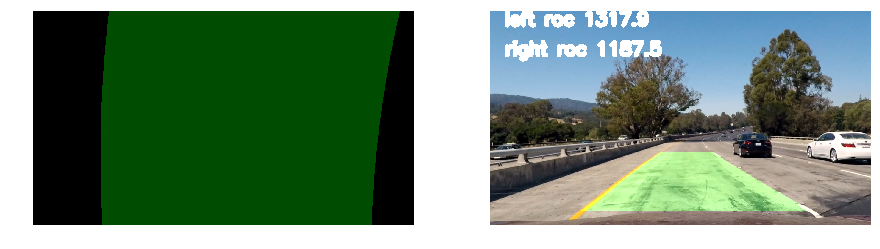

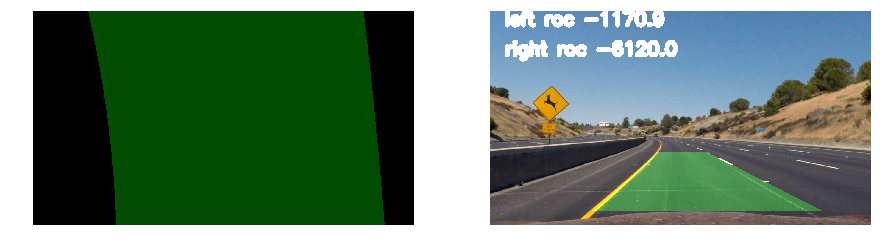

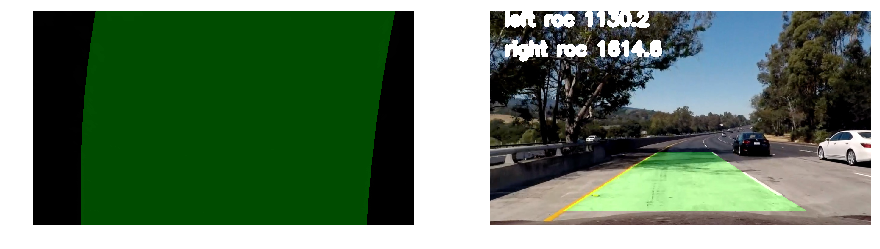

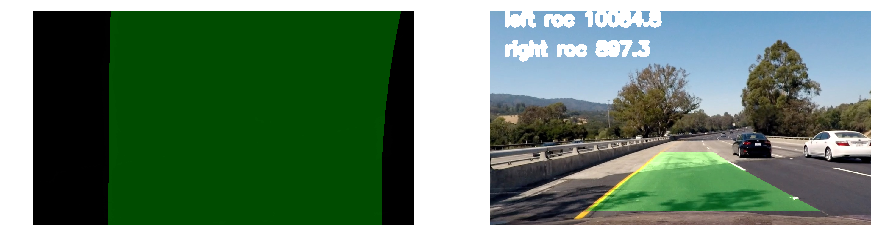

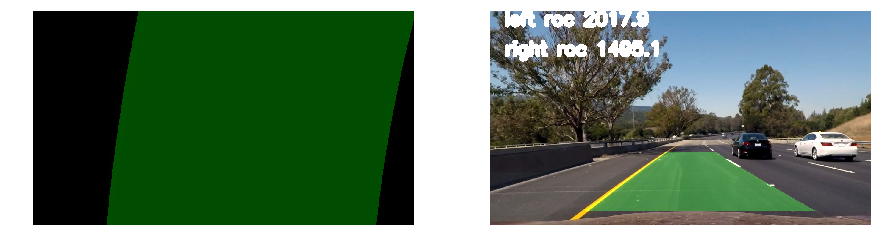

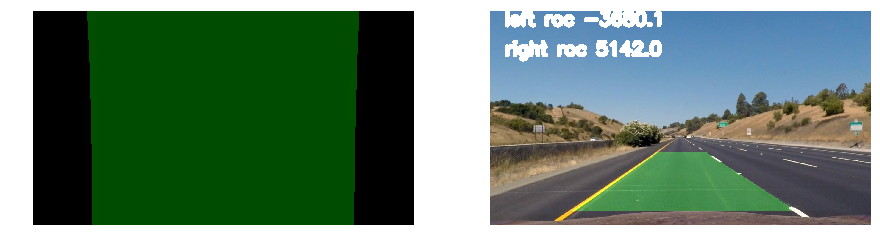

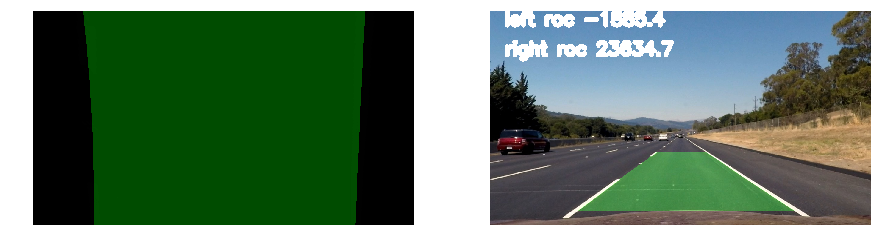

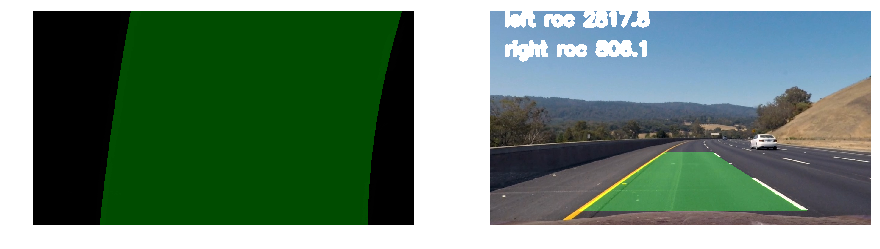

In [9]:
"""
this cell verifies that the get_lane_polynoms function works and 
confirming reasonable roc values
"""
lane_overlays = []
src, dst = cam_params['src_pts'], cam_params['dst_pts']
minv = cv2.getPerspectiveTransform(dst, src)
xvals = []
xflat = np.array([])
yvals = []
yflat = np.array([])
for bin_warped, orig in zip(warped, origs):
    (leftx, lefty), (rightx, righty) = get_lane_polynoms(bin_warped)
    xvals.append(leftx)
    xflat = np.hstack((xflat, leftx))
    yvals.append(lefty)
    yflat = np.hstack((yflat, lefty))
    left_roc = get_roc(leftx, lefty, bin_warped.shape[0])
    right_roc = get_roc(rightx, righty, bin_warped.shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    overlay_wrp = np.zeros((bin_warped.shape[0], bin_warped.shape[1], 3), dtype=np.uint8)
    lpts = np.vstack((left_fitx, ploty)).T
    rpts = np.vstack((right_fitx, ploty)).T[::-1, :]
    pts = np.vstack((lpts, rpts))
    pts = pts.reshape((1, -1, 2)).astype('int32')
    cv2.fillPoly(overlay_wrp, pts, (0, 255, 0))
    overlay = cv2.warpPerspective(overlay_wrp, minv, orig.shape[:2][::-1], None)
    combined = cv2.addWeighted(orig, 1, overlay, .3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(combined, 'left roc {:.1f}'.format(left_roc), (50, 50), font, 
                2, (255, 255, 255), cv2.LINE_AA) 
    cv2.putText(combined, 'right roc {:.1f}'.format(right_roc), (50, 150), font, 
                2, (255, 255, 255), cv2.LINE_AA) 
    combined_wrp = cv2.addWeighted(cv2.cvtColor(bin_warped, cv2.COLOR_GRAY2RGB), 
                                   1, overlay_wrp, .3, 0)
    
    plt.figure(figsize=(15, 30))
    plt.subplot(1, 2, 1)
    plt.imshow(combined_wrp)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(combined)
    plt.axis('off')
    plt.show()
        

In [9]:
class Lane():
    def __init__(self, ydim, n=5):
        # was the line detected in the last iteration?
        self.detected = False  
        
        self.ydim = ydim
        self.n = n
        
        self.end = 0
        self.count = 0
        
        self.best_fit = np.array([0., 0., 0.])
        
        self.coefs = [np.array([0., 0., 0.]) for _ in range(self.n)]
        
        self.weights = np.array([5, 3, 2] + (self.n - 3) * [1])
        
        self.roc = 0.
        
        self.bestx = []
        self.besty = []
        
    
    def sanity_check(self, roc):
        maxroc = 10000
        if not self.detected:
            if roc < maxroc:
                return True
            else:
                return False
        else:
            if abs(self.roc - roc)/self.roc < 2.5:
                return True
            else:
                return False
            
    def compute_bestxy(self, px_spacing=5):
        self.besty = np.linspace(0, self.ydim/px_spacing-1, self.ydim/px_spacing) * px_spacing
        a, b, c = self.best_fit
        self.bestx = a*self.besty**2 + b*self.besty + c
        return self.bestx, self.besty
        
    def compute_roc(self, yeval=None):
        if not yeval:
            yeval = self.ydim
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        A, B, _ = np.polyfit(self.besty*ym_per_pix, self.bestx*xm_per_pix, 2)
        self.roc = ((1 + (2*A*yeval*ym_per_pix+B)**2)**1.5)/(2*A)
        return self.roc
        
    def compute_best_fit(self):
        self.best_fit = np.dot(self.weights, self.coefs)/sum(self.weights[:self.count])
        return self.best_fit
        
    def add_coefs(self, coefs):
        self.count += 1
        self.coefs = [coefs] + self.coefs[:-1]
        self.compute_best_fit()
        self.compute_bestxy()
        self.compute_roc()
        
    def clear(self):
        self.count = 0
        self.coefs = [np.array([0., 0., 0.]) for _ in range(self.n)]
        self.bestx = []
        self.besty = []
        self.best_fit = np.array([0., 0., 0.])
        self.roc = 0.

In [10]:
"""
this is the lane finding pipeline.
make sure to define m and minv before calling the function.
"""
def process_image(img):
    global left_lane, right_lane, m, minv
    img = cv2.undistort(img, mtx, dist, None, mtx)
    thresh = threshold(img)
    warped = cv2.warpPerspective(thresh, m, (img.shape[1], img.shape[0]))
    if not (left_lane.detected and right_lane.detected):
        (leftx, lefty), (rightx, righty) = get_lane_polynoms(warped)
    else:
        margin = 100
        nzy, nzx = np.array(warped.nonzero())
        left_line = left_fit[0]*nzy**2 + left_fit[1]*nzy + left_fit[2]
        right_line = right_fit[0]*nzy**2 + right_fit[1]*nzy + right_fit[2]
        left_lane_inds = (nzx >= (left_line - margin)) & (nzx <= (left_line + margin))
        right_lane_inds = (nzx >= (right_line - margin)) & (nzx <= (right_line + margin))
        leftx = nzx[left_lane_inds]
        lefty = nzy[left_lane_inds]
        rightx = nzx[right_lane_inds]
        righty = nzy[right_lane_inds]
    left_roc = get_roc(leftx, lefty, warped.shape[0])
    right_roc = get_roc(rightx, righty, warped.shape[0])
    if left_lane.sanity_check(left_roc) and len(leftx) > 1000:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_lane.add_coefs(left_fit)
    else:
        left_lane.detected = False
    if right_lane.sanity_check(right_roc) and len(rightx) > 1000:
        right_fit = np.polyfit(righty, rightx, 2)
        right_lane.add_coefs(right_fit)
    else:
        right_lane.detected = False
    left_fitx = left_lane.bestx
    right_fitx = right_lane.bestx
    left_fity = left_lane.besty
    right_fity = right_lane.besty
    
    #calculate vehicle positioning relative to center of lane
    lane_center = (right_lane.bestx[-1] + left_lane.bestx[-1])/2
    offset_pix = img.shape[1]/2 - lane_center
    xm_per_pix = 3.7/700
    offset_meters = offset_pix * xm_per_pix
    
    overlay_wrp = np.zeros((warped.shape[0], warped.shape[1], 3), dtype=np.uint8)
    lpts = np.vstack((left_fitx, left_fity)).T
    rpts = np.vstack((right_fitx, right_fity)).T[::-1, :]
    pts = np.vstack((lpts, rpts))
    pts = pts.reshape((1, -1, 2)).astype('int32')
    cv2.fillPoly(overlay_wrp, pts, (0, 255, 0))
    overlay = cv2.warpPerspective(overlay_wrp, minv, img.shape[:2][::-1], None)
    combined = cv2.addWeighted(img, 1, overlay, .3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(combined, 'left roc {:.1f}'.format(left_lane.roc), (50, 50), font, 
                2, (255, 255, 255), cv2.LINE_AA) 
    cv2.putText(combined, 'right roc {:.1f}'.format(right_lane.roc), (50, 150), font, 
                2, (255, 255, 255), cv2.LINE_AA) 
    cv2.putText(combined, 'offset {:.1f}'.format(offset_meters), (50, 250), font, 
                2, (255, 255, 255), cv2.LINE_AA) 
    return combined

In [11]:
cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
src_pts, dst_pts = cam_params['src_pts'], cam_params['dst_pts']
m = cv2.getPerspectiveTransform(src_pts, dst_pts)
minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
left_lane, right_lane = Lane(720), Lane(720)
video_in = 'project_video.mp4'
video_out = 'project_video_results.mp4'
clip = VideoFileClip(video_in)
proc_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time proc_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video project_video_results.mp4
[MoviePy] Writing video project_video_results.mp4


100%|█████████▉| 1260/1261 [04:40<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_results.mp4 

CPU times: user 9min 51s, sys: 15.7 s, total: 10min 7s
Wall time: 4min 41s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))